In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Number of samples
n_samples = 10000000

# Exogenous noise variables
U1 = np.random.normal(50, 10, n_samples)  # Noise for Age
U2 = np.random.normal(0, 1, n_samples)  # Noise for PreTreatmentHealthScore
U3 = np.random.uniform(0, 1, n_samples)  # Noise for Treatment
U4 = np.random.normal(0, 5, n_samples)  # Noise for RecoveryTime

# SCM equations
def f1(u1):
    return u1  # Age is directly derived from exogenous noise U1

def f2(age, u2):
    return age/10 + u2  # PreTreatmentHealthScore is a function of Age

def f3(pretreatment_health_score, u3):
    # Treatment is more likely if PreTreatmentHealthScore is lower
    return (pretreatment_health_score < 6) & (u3 < 0.8)

def f4(pretreatment_health_score, treatment, u4):
    # RecoveryTime is influenced by PreTreatmentHealthScore and Treatment
    base_recovery_time = 30 - 3 * pretreatment_health_score
    treatment_effect = np.where(treatment, -5, 0) # Treatment reduces RecoveryTime by 5
    return base_recovery_time + treatment_effect + u4

# Generate observational data
Age = f1(U1)
PreTreatmentHealthScore = f2(Age, U2)
Treatment = f3(PreTreatmentHealthScore, U3)
RecoveryTime = f4(PreTreatmentHealthScore, Treatment, U4)

# Interventional Distribution: Simulate an intervention where all individuals receive treatment
Treatment_intervention = np.ones(n_samples, dtype=bool)
RecoveryTime_intervention = f4(PreTreatmentHealthScore, Treatment_intervention, U4)

# Interventional Distribution: Simulate an intervention where all individuals whot don't receive treatment
Non_Treatment_intervention = np.zeros(n_samples, dtype=bool)
RecoveryTime_intervention_Non_Treated = f4(PreTreatmentHealthScore, Non_Treatment_intervention, U4)


# Counterfactual: What would the RecoveryTime be for those who didn't receive treatment, had they received it?
Treatment_counterfactual = np.ones(np.sum(Treatment == 0), dtype=bool)
print(Treatment_counterfactual)
print(Treatment_counterfactual.shape)
noise_for_counterfactual = U4[Treatment == 0]
pre_treatment_health_scores_for_counterfactual = PreTreatmentHealthScore[Treatment == 0]
RecoveryTime_counterfactual = f4(pre_treatment_health_scores_for_counterfactual, Treatment_counterfactual, noise_for_counterfactual)

# Factial: What is the RecoveryTime be for those who get treated?
Treatment_factual = np.ones(np.sum(Treatment == 1), dtype=bool)
print(Treatment_factual)
print(Treatment_factual.shape)
noise_for_factual = U4[Treatment == 1]
pre_treatment_health_scores_for_factual = PreTreatmentHealthScore[Treatment == 1]
RecoveryTime_factual = f4(pre_treatment_health_scores_for_factual, Treatment_factual, noise_for_factual)

[ True  True  True ...  True  True  True]
(3915804,)
[ True  True  True ...  True  True  True]
(6084196,)


Mean of Observational RecoveryTime: 11.959325012726307
Mean of Interventional RecoveryTime: 10.001423012726306
Mean of Interventional RecoveryTime for Non-Treated: 15.00142301272631


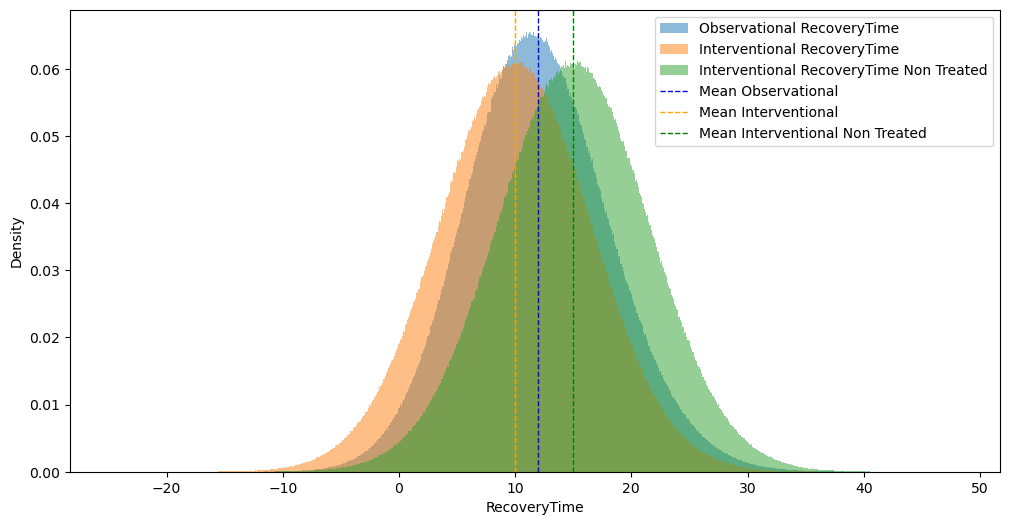

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the means
mean_observational = np.mean(RecoveryTime)
mean_interventional = np.mean(RecoveryTime_intervention)
mean_interventional_non_treated = np.mean(RecoveryTime_intervention_Non_Treated)

# Print the means
print("Mean of Observational RecoveryTime:", mean_observational)
print("Mean of Interventional RecoveryTime:", mean_interventional)
print("Mean of Interventional RecoveryTime for Non-Treated:", mean_interventional_non_treated)

# Plot
plt.figure(figsize=(12, 6))

# Density instead of frequency
plt.hist(RecoveryTime, bins=1000, alpha=0.5, label="Observational RecoveryTime", density=True)
plt.hist(RecoveryTime_intervention, bins=1000, alpha=0.5, label="Interventional RecoveryTime", density=True)
plt.hist(RecoveryTime_intervention_Non_Treated, bins=1000, alpha=0.5, label="Interventional RecoveryTime Non Treated", density=True)

# Plot vertical lines representing the means
plt.axvline(mean_observational, color='blue', linestyle='dashed', linewidth=1, label='Mean Observational')
plt.axvline(mean_interventional, color='orange', linestyle='dashed', linewidth=1, label='Mean Interventional')
plt.axvline(mean_interventional_non_treated, color='green', linestyle='dashed', linewidth=1, label='Mean Interventional Non Treated')

# Labels and legend
plt.xlabel("RecoveryTime")
plt.ylabel("Density")
plt.legend()
plt.show()

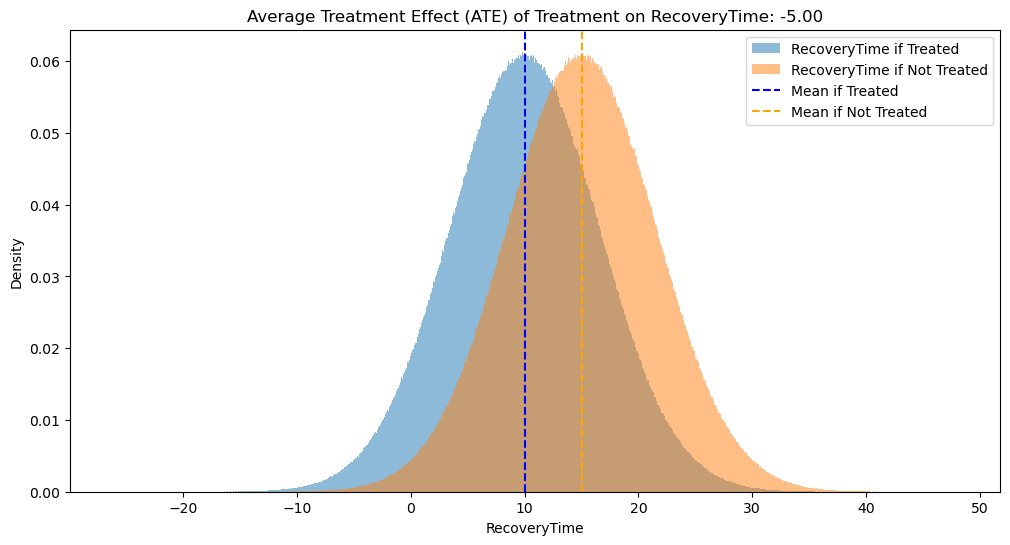

In [25]:

# Calculate the average outcome if everyone received the treatment
RecoveryTime_if_treated = f4(PreTreatmentHealthScore, np.ones(n_samples, dtype=bool), U4)

# Calculate the average outcome if no one received the treatment
RecoveryTime_if_not_treated = f4(PreTreatmentHealthScore, np.zeros(n_samples, dtype=bool), U4)

# Now calculate the Average Treatment Effect (ATE)
ATE = np.mean(RecoveryTime_if_treated) - np.mean(RecoveryTime_if_not_treated)

# Plot the distributions
plt.figure(figsize=(12, 6))
plt.hist(RecoveryTime_if_treated, bins=1000, alpha=0.5, label="RecoveryTime if Treated", density=True)
plt.hist(RecoveryTime_if_not_treated, bins=1000, alpha=0.5, label="RecoveryTime if Not Treated", density=True)
plt.axvline(np.mean(RecoveryTime_if_treated), color='blue', linestyle='dashed', label='Mean if Treated')
plt.axvline(np.mean(RecoveryTime_if_not_treated), color='orange', linestyle='dashed', label='Mean if Not Treated')
plt.xlabel("RecoveryTime")
plt.ylabel("Density")
plt.title(f"Average Treatment Effect (ATE) of Treatment on RecoveryTime: {ATE:.2f}")
plt.legend()
plt.show()

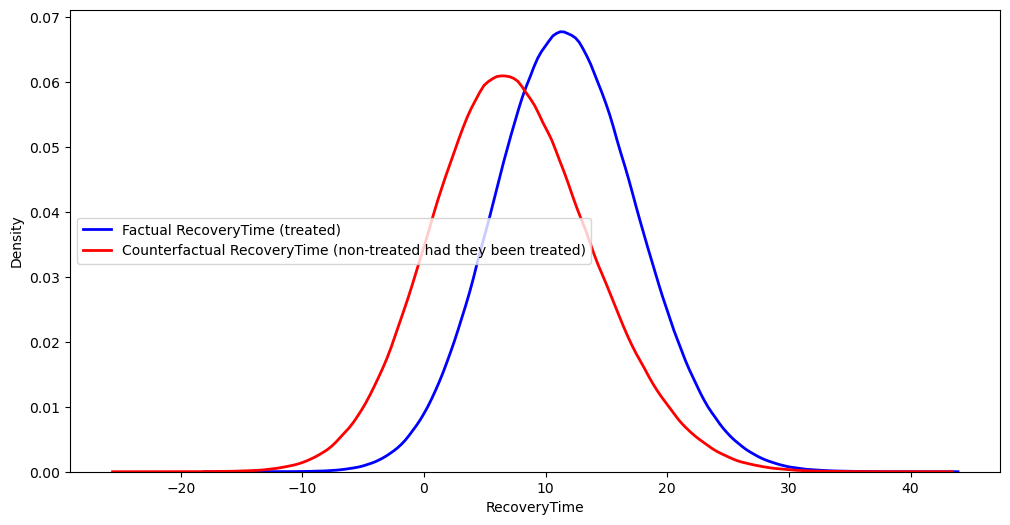

Mean RecoveryTime for Factual: 11.733574444326251
Mean RecoveryTime for Counterfactual: 7.310085853988399
Difference in Means (Factual - Counterfactual): 4.423488590337852


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Density plots for the distributions
plt.figure(figsize=(12, 6))

# Plot the distributions
sns.kdeplot(RecoveryTime_factual, label="Factual RecoveryTime (treated)", linewidth=2, color='blue')
sns.kdeplot(RecoveryTime_counterfactual, label="Counterfactual RecoveryTime (non-treated had they been treated)", linewidth=2, color='red')

# Labels and legend
plt.xlabel("RecoveryTime")
plt.ylabel("Density")
plt.legend()

# Show plot
plt.show()

# Calculate the means
mean_factual = np.mean(RecoveryTime_factual)
mean_counterfactual = np.mean(RecoveryTime_counterfactual)

# Print the means
print(f"Mean RecoveryTime for Factual: {mean_factual}")
print(f"Mean RecoveryTime for Counterfactual: {mean_counterfactual}")

# Print the difference of means
print(f"Difference in Means (Factual - Counterfactual): {mean_factual - mean_counterfactual}")

# Abduction

In the abduction step, we infer the state of the world, the exogenous noise $\boldsymbol{\epsilon} = (U_1, U_2, U_3, U_4)$, given the observed data $(\text{Age}, \text{PreTreatmentHealthScore}, \text{Treatment}, \text{RecoveryTime})$.  Here, the inferred state of the world is already given as $(U_1, U_2, U_3, U_4)$ for each sample, as these are the exogenous noise variables we've sampled. Formally, 

$$
P_{\mathfrak{G}}(\boldsymbol{\epsilon} \mid \mathbf{x})=P_{\mathfrak{G}}\left(U_1, U_2, U_3, U_4 \mid \text { Age, PreTreatmentHealthScore, Treatment, RecoveryTime }\right)
$$

# Action

In this step, we are simulating an intervention, specifically setting the Treatment variable to 1 for all samples. The modified structural causal model is denoted by $\widetilde{\mathfrak{G}}$.

Formally, this corresponds to:
$$
\widetilde{\mathfrak{G}}=\mathfrak{G}_{\mathbf{x} ; \mathrm{do}(\text { Treatment:=1) }}=\left(\widetilde{\mathbf{S}}, P_{\mathfrak{G}}(\boldsymbol{\epsilon} \mid \mathbf{x})\right)
$$
intervention.

# Prediction

Finally, we compute the counterfactual distribution for RecoveryTime had everyone received the treatment.

Formally, we compute:
$$
P_{\widetilde{G}}(\text { RecoveryTime })=P_{\widetilde{G}}\left(\mathrm{f} 4\left(\text { PreTreatmentHealthScore, } 1, U_4\right)\right)
$$
This gives us the counterfactual distribution of RecoveryTime, assuming all individuals received treatment, with the state of the world remaining consistent with the original observations.

# Diffusion and Assumption

Certainly, let's formalize the three assumptions mentioned in the excerpt:

The SCM is known and the intervention is identifiable: This assumption implies that the structural causal model (SCM) $\mathfrak{G} = (\mathbf{S}, P(\boldsymbol{\epsilon}))$ is known. Here, $\mathbf{S}$ represents a set of structural equations that describe how endogenous variables are generated from exogenous variables and noise, and $P(\boldsymbol{\epsilon})$ represents the distribution of exogenous noise variables $\boldsymbol{\epsilon}$. The intervention being identifiable means that for an intervention $\operatorname{do}(X = x)$, there exists a function $\pi$ such that $P(Y| \operatorname{do}(X = x)) = \pi(P(X, Y), x)$ for every $X$ and $Y$ in the SCM.

The variables over which the counterfactuals will be estimated need to contain enough information to recover their causes: Let $Y$ be the variable over which the counterfactuals are to be estimated, and let $X$ be the causes of $Y$. This assumption implies that there exists an anti-causal predictor $g$ such that $X = g(Y, \boldsymbol{\eta})$, where $\boldsymbol{\eta}$ may represent additional noise or information.

All endogenous variables in the training set are annotated: This assumption implies that for the training dataset $D = {(x_1, y_1), (x_2, y_2), \dots, (x_n, y_n)}$, both the causes $x_i$ and the effects $y_i$ are observed and labeled.

In mathematical notations, the assumptions can be represented as:

$\mathfrak{G} = (\mathbf{S}, P(\boldsymbol{\epsilon}))$ is known and $\exists \pi$ such that $P(Y | \operatorname{do}(X = x)) = \pi(P(X, Y), x)$.

$\exists g$ such that $X = g(Y, \boldsymbol{\eta})$.

$D = {(x_1, y_1), (x_2, y_2), \dots, (x_n, y_n)}$ where $x_i$ and $y_i$ are observed and annotated.